# Dataset Introduction: Automated Cardiac Diagnosis Challenge (ACDC)

## Overview

The **Automated Cardiac Diagnosis Challenge (ACDC)** dataset was created for a competition that took place during the MICCAI 2017 conference. The challenge aimed to assess the performance of automatic methods for two key tasks:

1. **Segmentation**: The segmentation of the left ventricular endocardium and epicardium, and the right ventricular endocardium for both end diastolic and end systolic phases.
2. **Classification**: The classification of cardiac pathologies into five categories:
   - Normal Case
   - Heart Failure with Infarction
   - Dilated Cardiomyopathy
   - Hypertrophic Cardiomyopathy
   - Abnormal Right Ventricle

The challenge remained open for submissions until the end of 2022, and its final leaderboard was published afterward. Although the competition is now closed, the dataset and corresponding groundtruth are still publicly available for research purposes.

## Dataset Download Process

The ACDC dataset was downloaded by visiting the official [ACDC challenge website](https://www.creatis.insa-lyon.fr/Challenge/acdc/index.html), where the data is available in a compressed ZIP file format. After downloading, the ZIP file was extracted, revealing two main folders: `training` and `testing`. Each of these folders contains subfolders for individual patients, and within each patient's folder, several `.nii.gz` files can be found, along with configuration files like `Info.cfg` and a mandatory citation file `MANDATORY CITATION.md`.

The dataset contains the following structure:

/training /patient001 - Info.cfg - MANDATORY CITATION.md - patient001_4d.nii.gz - patient001_frame01_gt.nii.gz - patient001_frame01.nii.gz - patient001_frame14_gt.nii.gz - patient001_frame14.nii.gz ... /testing /patient101 - Info.cfg - MANDATORY CITATION.md - patient101_4d.nii.gz - patient101_frame01_gt.nii.gz - patient101_frame01.nii.gz - patient101_frame14_gt.nii.gz - patient101_frame14.nii.gz ..



Each `.nii.gz` file represents MRI scan data and ground truth segmentations for various cardiac structures, which are essential for training and evaluating the models.

## Citation

If you use the ACDC dataset in your project, you must reference the following paper:

> O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, et al.  
> "Deep Learning Techniques for Automatic MRI Cardiac Multi-structures Segmentation and Diagnosis: Is the Problem Solved?"  
> IEEE Transactions on Medical Imaging, vol. 37, no. 11, pp. 2514-2525, Nov. 2018.  
> DOI: [10.1109/TMI.2018.2837502](https://doi.org/10.1109/TMI.2018.2837502)

## Organizers

The challenge was organized by the following experts in the field of medical imaging:

- **Pierre-Marc Jodoin**  
  Videos & Images Theory and Analytics Laboratory, University of Sherbrooke, Canada
- **Alain Lalande**  
  Medical Imaging team, Le2i laboratory, University of Burgundy, France  
  MRI Department, University Hospital of Dijon, France
- **Olivier Bernard**  
  Creatis laboratory, University of Lyon, France

## Medical Expert Committee Members

- **Olivier Humbert**  
  Physician/Expert in medical imaging, CEA, Nice, France  
  Nuclear Medicine Department, University of Nice-Sophia Antipolis, France

- **Alain Lalande**  
  Biophysicist, MRI Department, University Hospital of Dijon, France

## Technical Advisers

- **Clement Zotti**  
  University of Sherbrooke, Canada

- **Frederic Cervenansky**  
  Creatis laboratory, University of Lyon, France

---

### Summary

This dataset provides a rich resource for exploring segmentation and classification tasks in cardiac MRI analysis. The challenge dataset is widely used for benchmarking and testing new methods in the field of medical image segmentation. By participating in this project, we leverage the dataset to explore model ensembles and their impact on performance in segmentation tasks.


In [ ]:
#google drive
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/My\ Drive/testing


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MANDATORY_CITATION.md  patient108  patient116  patient124  patient132  patient140  patient148
patient101	       patient109  patient117  patient125  patient133  patient141  patient149
patient102	       patient110  patient118  patient126  patient134  patient142  patient150
patient103	       patient111  patient119  patient127  patient135  patient143  training.zip
patient104	       patient112  patient120  patient128  patient136  patient144
patient105	       patient113  patient121  patient129  patient137  patient145
patient106	       patient114  patient122  patient130  patient138  patient146
patient107	       patient115  patient123  patient131  patient139  patient147


In [ ]:
!pip install nibabel
!pip install virtualenv
!virtualenv myenv
!source myenv/bin/activate
!pip install numpy pandas
!pip install nibabel matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 22.6 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 2965ms
  creator CPython3Posix(dest=/content/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==75.2.0, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.nn.functional as F
import pandas as pd
import nibabel as nib
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import random


In [ ]:
# NIfTI

data_dir = '/content/drive/MyDrive/testing/'
file_paths = glob.glob(os.path.join(data_dir, '**/*.nii.gz'), recursive=True)
print(f"Found {len(file_paths)} .nii.gz files")

# Data cleaning
target_size = (192, 256, 8)

# Padding data
def pad_tensor(tensor):
    # Get tensor shape
    current_shape = tensor.shape

    # Calculate padding size
    padding = [
        0, max(0, target_size[2] - current_shape[2]),  # Padding for the third dimension
        0, max(0, target_size[1] - current_shape[1]),  # Padding for the second dimension
        0, max(0, target_size[0] - current_shape[0])   # Padding for the first dimension
    ]

    # Use padding to pad the tensor
    return F.pad(tensor, padding, mode='constant', value=0)

# Data normalization
def min_max_normalize(img_data):
    # Calculate max-min value
    min_val = img_data.min()
    max_val = img_data.max()

    # Normalize data
    normalized_data = (img_data - min_val) / (max_val - min_val)

    return normalized_data

class MedicalDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths  # Batch file paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # print(f"Accessing index: {idx}")
        img = nib.load(self.file_paths[idx])
        img_data = img.get_fdata()

        # Check for invalid values
        nan_count = np.isnan(img_data).sum()
        inf_count = np.isinf(img_data).sum()

        if nan_count > 0:
            print(f"Data {self.file_paths[idx]} has {nan_count} NaN values.")
        if inf_count > 0:
            print(f"Data {self.file_paths[idx]} has {inf_count} Inf values.")

        normalized_data = min_max_normalize(img_data)  # Normalize data
        # print(f"Normalized shape: {normalized_data.shape}")
        img_tensor = torch.tensor(normalized_data, dtype=torch.float32)

        # Check for dimension and trim or pad
        if img_tensor.ndim == 4:
            img_tensor = img_tensor[:, :, :, 0]  # Use first channel
        elif img_tensor.ndim == 3:
            img_tensor = img_tensor[:192, :256, :8]  # Cut to target size if applicable

        if img_tensor.shape != target_size:
            img_tensor = pad_tensor(img_tensor)  # Pad if not matching target size

        print(f"Processed {self.file_paths[idx]}: Shape {img_tensor.shape}")  # Debug print
        return img_tensor

# Start dataset
dataset = MedicalDataset(file_paths)

# Start DataLoader
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


Found 250 .nii.gz files


In [ ]:
img = nib.load('/content/drive/MyDrive/testing/patient101/patient101_frame01.nii.gz')

# View basic information about the file
print(img)
print("Image shape:", img.shape)
print("Image affine:", img.affine)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (232, 256, 10)
affine:
[[-1. -0.  0.  0.]
 [-0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 232 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.       1.64062  1.64062 10.       1.       1.       1.       1.     ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_

Image data shape: (232, 256, 10)


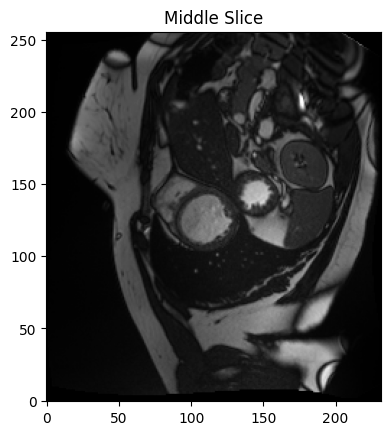

In [ ]:
image_data = img.get_fdata()
# Check the shape of the image (usually three-dimensional)
print("Image data shape:", image_data.shape)

# Visualize the middle layer slice
slice_0 = image_data[:, :, image_data.shape[2] // 2]  # Cross-sectional slice of the middle layer

plt.imshow(slice_0.T, cmap="gray", origin="lower")  # Display the image
plt.title("Middle Slice")
plt.show()

In [ ]:
# Split dataset

labels = [random.randint(0, 1) for _ in range(len(file_paths))]
df = pd.DataFrame({
    'filename': file_paths,
    'label': labels
})
csv_path = '/content/drive/MyDrive/labels.csv'
df.to_csv(csv_path, index=False)

X_train, X_temp, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(np.stack([nib.load(fp).get_fdata() for fp in X_train]), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(np.stack([nib.load(fp).get_fdata() for fp in X_val]), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:

# set CNNmodel
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2, 2)
        self.fc1 = nn.Linear(32 * 96 * 128 * 4, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 96 * 128 * 4)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Simple3DCNN()

#
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:  # Use train_loader here
        inputs = inputs.unsqueeze(1)  # Add channel dimension (batch, channels, depth, height, width)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

# Evaluate
model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in val_loader:  # Use val_loader
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader)}")
